Optimization terminated successfully.
         Current function value: -3783.364956
         Iterations: 119
         Function evaluations: 122
         Gradient evaluations: 122
Estimated ESE parameters (theta_hat):
  term u^0 v^1: 2.3341
  term u^0 v^2: -13.2816
  term u^0 v^3: 43.3614
  term u^0 v^4: -29.0829
  term u^0 v^5: 2.4034
  term u^1 v^0: 3.2262
  term u^1 v^1: 104.1263
  term u^1 v^2: -169.2926
  term u^1 v^3: 77.1785
  term u^1 v^4: -17.2749
  term u^2 v^0: -13.4740
  term u^2 v^1: -134.2055
  term u^2 v^2: 137.9053
  term u^2 v^3: -25.9225
  term u^3 v^0: 10.9692
  term u^3 v^1: 58.6453
  term u^3 v^2: -12.5346
  term u^4 v^0: 33.0885
  term u^4 v^1: -32.6393
  term u^5 v^0: -27.8307

ESE copula log-likelihood and information criteria:
  loglik = 3783.365
  AIC    = -7526.730
  BIC    = -7385.738

Empirical tail metrics (from data):
  alpha = 0.05:
    TDI1_emp = P(u < 0.05 | v > 0.95) = 0.3835
    TDI2_emp = P(u > 0.95 | v < 0.05) = 0.4894
    JP_emp   = P(u < 0.05, v >

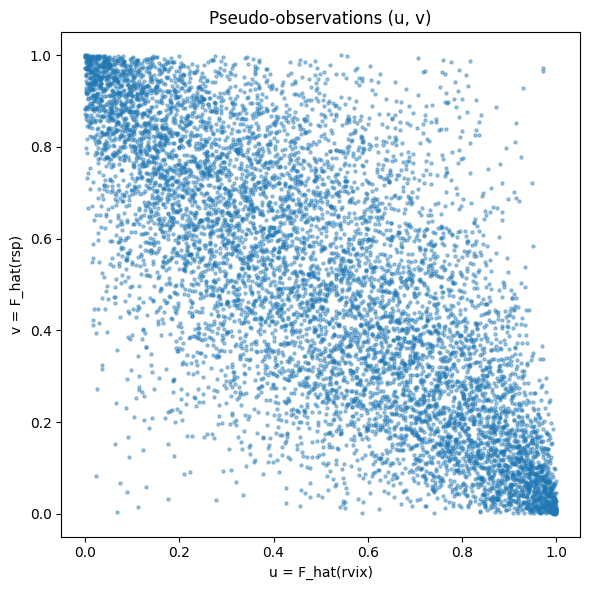

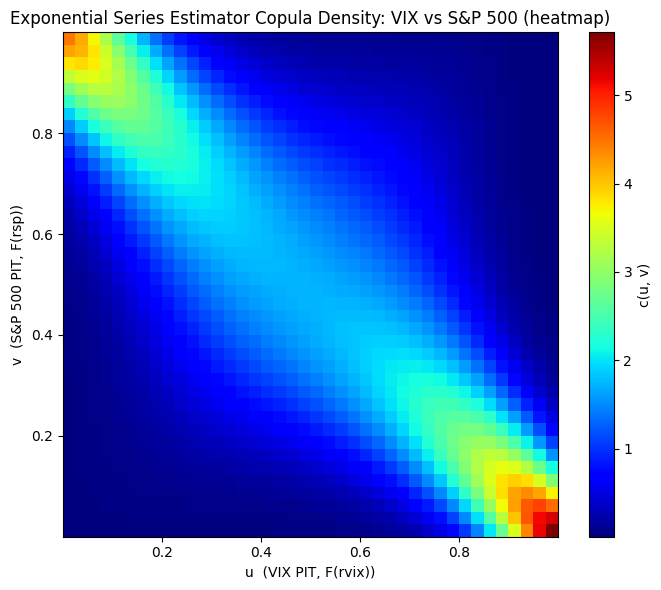

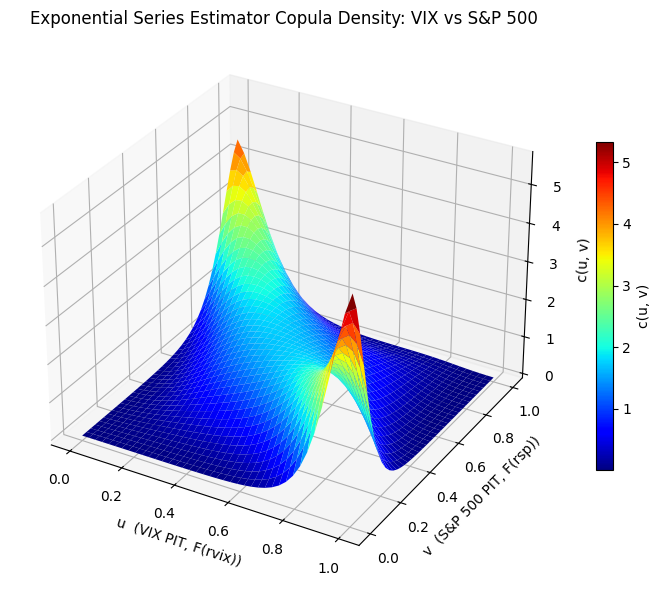

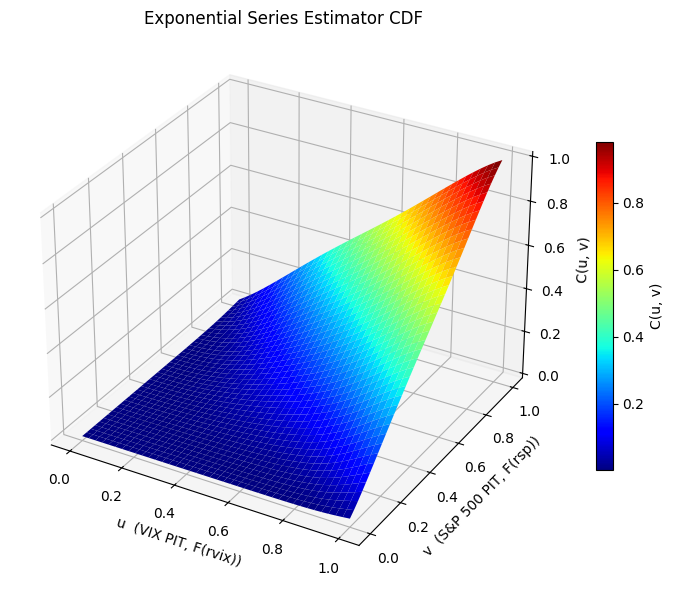

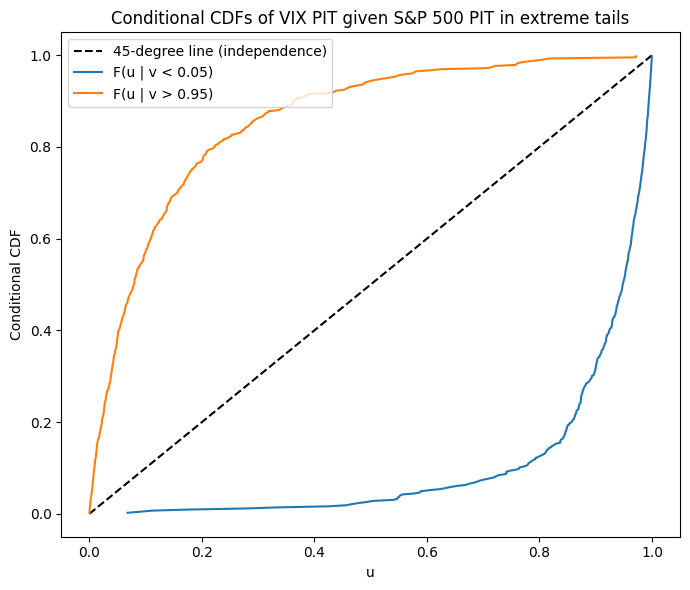

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import rankdata
from scipy import optimize

def load_returns(csv_path):
    df = pd.read_csv(csv_path)

    # Standardize column names just in case
    df.columns = [c.strip().lower() for c in df.columns]

    if "date" not in df.columns or "rsp" not in df.columns or "rvix" not in df.columns:
        raise ValueError("CSV must contain 'Date', 'rsp', 'rvix' columns.")

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    df = df[["date", "rsp", "rvix"]].dropna().reset_index(drop=True)

    return df


# Sklar step: pseudo-observations (empirical PITs)

def pseudo_observations(x):
    """
    Map a 1D array x to U(0,1) pseudo-observations using empirical CDF.

    u_t = rank(x_t) / (n + 1), which keeps points away from exact 0 and 1.
    """
    x = np.asarray(x)
    n = x.shape[0]
    ranks = rankdata(x, method="average")  # 1..n
    u = ranks / (n + 1.0)
    return u

#  Exponential Series Estimator (ESE) for the copula

def build_basis(u, v, m):
    """
    Build polynomial basis matrix for ESE.
    """
    u = np.asarray(u)
    v = np.asarray(v)
    T = u.shape[0]

    exponents = []
    basis_cols = []

    for i in range(m):
        for j in range(m):
            if i == 0 and j == 0:
                continue
            if i + j >= m:
                continue
            exponents.append((i, j))
            basis_cols.append((u ** i) * (v ** j))

    Phi_data = np.column_stack(basis_cols)  # shape (T, K)
    return Phi_data, exponents


def build_basis_on_grid(U, V, exponents):
    """
    Build basis matrix on a grid given exponents.
    """
    u_flat = U.ravel()
    v_flat = V.ravel()

    basis_cols = []
    for (i, j) in exponents:
        basis_cols.append((u_flat ** i) * (v_flat ** j))

    Phi_grid = np.column_stack(basis_cols)
    return Phi_grid


def ese_log_partition(theta, Phi_grid):
    """
    Compute log-partition function
    """
    s_grid = Phi_grid @ theta  # shape (G,)
    max_s = np.max(s_grid)
    w = np.exp(s_grid - max_s)  # stabilize
    Z = w.mean()               # domain area is 1
    psi = np.log(Z) + max_s
    return psi


def ese_loglik_and_grad(theta, Phi_data, Phi_grid):
    """
    Log-likelihood and gradient for the ESE copula model.
    """
    T = Phi_data.shape[0]

    # Data part: sum over observations
    s_data = Phi_data @ theta
    loglik_data = s_data.sum()

    # Partition function and its gradient via grid
    s_grid = Phi_grid @ theta
    max_s = np.max(s_grid)
    w = np.exp(s_grid - max_s)
    Z = w.mean()
    psi = np.log(Z) + max_s

    # Expected phi under current model (approx on grid)
    weighted_phi = (w[:, None] * Phi_grid)
    E_phi = weighted_phi.sum(axis=0) / w.sum()

    loglik = loglik_data - T * psi
    grad = Phi_data.sum(axis=0) - T * E_phi

    return loglik, grad


def estimate_copula_ese(u, v, m=6, grid_size=40, verbose=True):
    """
    Estimate the copula density c(u, v) via ESE.
    """
    # Build basis at data
    Phi_data, exponents = build_basis(u, v, m)
    K = Phi_data.shape[1]

    # Build grid over [0,1] x [0,1]
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U_grid, V_grid = np.meshgrid(grid_axis, grid_axis)
    Phi_grid = build_basis_on_grid(U_grid, V_grid, exponents)

    def obj(theta):
        ll, grad = ese_loglik_and_grad(theta, Phi_data, Phi_grid)
        return -ll, -grad

    theta0 = np.zeros(K)

    result = optimize.minimize(
        fun=lambda th: obj(th)[0],
        x0=theta0,
        jac=lambda th: obj(th)[1],
        method="BFGS",
        options={"disp": verbose, "maxiter": 500}
    )

    if not result.success:
        raise RuntimeError(f"ESE optimization failed: {result.message}")

    theta_hat = result.x

    # Evaluate copula density on grid
    psi_hat = ese_log_partition(theta_hat, Phi_grid)
    log_c_grid = (Phi_grid @ theta_hat) - psi_hat
    C_grid = np.exp(log_c_grid).reshape(U_grid.shape)

    return theta_hat, exponents, U_grid, V_grid, C_grid


#  Tail-dependence indices (empirical version)

def tail_dependence_indices(u, v, alphas=(0.01, 0.05)):
    """
    Compute empirical tail-dependence indices as in the paper:
    """
    u = np.asarray(u)
    v = np.asarray(v)
    res = {}

    for a in alphas:
        mask1 = v > 1.0 - a
        mask2 = v < a

        # Avoid division by zero if tails empty
        if mask1.sum() == 0 or mask2.sum() == 0:
            res[a] = (np.nan, np.nan)
            continue

        tdi1 = np.mean(u[mask1] < a)
        tdi2 = np.mean(u[mask2] > 1.0 - a)
        res[a] = (tdi1, tdi2)

    return res

def joint_crash_probs(u, v, alphas=(0.01, 0.05)):
    """
    Empirical joint crash probabilities:
    """
    u = np.asarray(u)
    v = np.asarray(v)
    res = {}
    for a in alphas:
        jp = np.mean((u < a) & (v > 1.0 - a))
        res[a] = jp
    return res

# Conditional CDFs for u | v in extreme tails

def empirical_cdf_curve(x):
    """
    Return sorted x and empirical CDF values.
    """
    xs = np.sort(x)
    n = xs.shape[0]
    cdf = np.arange(1, n + 1) / (n + 1.0)
    return xs, cdf


def plot_conditional_cdfs(u, v, alpha=0.05):
    u = np.asarray(u)
    v = np.asarray(v)

    u_all, F_all = empirical_cdf_curve(u)

    mask_left = v < alpha
    mask_right = v > 1.0 - alpha

    u_left, F_left = empirical_cdf_curve(u[mask_left])
    u_right, F_right = empirical_cdf_curve(u[mask_right])

    plt.figure(figsize=(7, 6))
    plt.plot(u_all, u_all, "k--", label="45-degree line (independence)")
    plt.plot(u_left, F_left, label=f"F(u | v < {alpha:.2f})")
    plt.plot(u_right, F_right, label=f"F(u | v > {1-alpha:.2f})")
    plt.xlabel("u")
    plt.ylabel("Conditional CDF")
    plt.title("Conditional CDFs of VIX PIT given S&P 500 PIT in extreme tails")
    plt.legend()
    plt.tight_layout()


# Plotting helpers for copula visualization


def plot_pseudo_scatter(u, v):
    plt.figure(figsize=(6, 6))
    plt.scatter(u, v, s=5, alpha=0.4)
    plt.xlabel("u = F_hat(rvix)")
    plt.ylabel("v = F_hat(rsp)")
    plt.title("Pseudo-observations (u, v)")
    plt.tight_layout()


def plot_copula_heatmap(U, V, C):
    plt.figure(figsize=(7, 6))
    img = plt.imshow(
        C,
        origin="lower",
        extent=[U.min(), U.max(), V.min(), V.max()],
        aspect="auto",
        cmap="jet"  
    )
    plt.colorbar(img, label="c(u, v)")
    plt.xlabel('u  (VIX PIT, F(rvix))')
    plt.ylabel('v  (S&P 500 PIT, F(rsp))')
    plt.title("Exponential Series Estimator Copula Density: VIX vs S&P 500 (heatmap)")
    plt.tight_layout()


def plot_copula_surface(U, V, C):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        U,
        V,
        C,
        linewidth=0,
        antialiased=True,
        cmap="jet"  
    )

    # Add colorbar to show the scale
    fig.colorbar(surf, ax=ax, shrink=0.6, label="c(u, v)")

    ax.set_xlabel("u  (VIX PIT, F(rvix))")
    ax.set_ylabel("v  (S&P 500 PIT, F(rsp))")
    ax.set_zlabel("c(u, v)")
    ax.set_title("Exponential Series Estimator Copula Density: VIX vs S&P 500")
    plt.tight_layout()

def compute_cdf_from_density(U, V, C):
    """
    Approximate joint CDF C(u,v) from a density grid c(u,v).


    """
    # grid step sizes
    du = U[0, 1] - U[0, 0]
    dv = V[1, 0] - V[0, 0]

    # double cumulative sum from (0,0) up to (u_i, v_j)
    F = np.cumsum(np.cumsum(C, axis=0), axis=1) * du * dv

    # small numerical clean-up: enforce [0,1]
    F = F / F.max()
    F = np.clip(F, 0.0, 1.0)
    return F


def plot_copula_cdf_surface(U, V, C):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    # turn density grid into approximate CDF grid
    F = compute_cdf_from_density(U, V, C)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # same style as plot_copula_surface: smooth surface with jet colormap
    surf = ax.plot_surface(
        U,
        V,
        F,
        linewidth=0,
        antialiased=True,
        cmap="jet"
    )

    fig.colorbar(surf, ax=ax, shrink=0.6, label="C(u, v)")

    ax.set_xlabel("u  (VIX PIT, F(rvix))")
    ax.set_ylabel("v  (S&P 500 PIT, F(rsp))")
    ax.set_zlabel("C(u, v)")
    ax.set_title(f"Exponential Series Estimator CDF")
    plt.tight_layout()


# -----------------
# test new plot functions
# -----------------

# def plot_copula_heatmap(U, V, C, title_prefix="Copula"):
#     plt.figure(figsize=(7, 6))
#     img = plt.imshow(
#         C,
#         origin="lower",
#         extent=[U.min(), U.max(), V.min(), V.max()],
#         aspect="auto",
#         cmap="jet"
#     )
#     plt.colorbar(img, label="c(u, v)")
#     plt.xlabel("u  (VIX rank PIT, F^(rvix))")
#     plt.ylabel("v  (S&P 500 rank PIT, F^(rsp))")
#     plt.title(f"{title_prefix} density: VIX vs S&P 500 (heatmap)")
#     plt.tight_layout()

# def plot_copula_surface(U, V, C, title_prefix="Copula"):
#     from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111, projection="3d")

#     # normalise for colormap
#     norm = plt.Normalize(C.min(), C.max())
#     colors = cm.jet(norm(C))

#     # coloured net: use plot_surface with edgecolor + colormap, no extra wireframe
#     surf = ax.plot_surface(
#         U,
#         V,
#         C,
#         facecolors=colors,
#         linewidth=0.5,
#         edgecolor="k",      # grid lines
#         antialiased=True,
#         shade=False
#     )

#     # separate mappable for colourbar
#     mappable = cm.ScalarMappable(norm=norm, cmap=cm.jet)
#     mappable.set_array([])  # required in some Matplotlib versions
#     fig.colorbar(mappable, ax=ax, shrink=0.6, label="c(u, v)")

#     ax.set_xlabel("u  (VIX rank PIT, F^(rvix))")
#     ax.set_ylabel("v  (S&P 500 rank PIT, F^(rsp))")
#     ax.set_zlabel("Copula density c(u, v)")
#     ax.set_title(f"{title_prefix} density: VIX vs S&P 500")

#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.view_init(elev=30, azim=225)

#     plt.tight_layout()

# def compute_cdf_from_density(U, V, C):
#     """
#     Approximate joint CDF C(u,v) from a density grid c(u,v).

#     Assumes U,V come from np.meshgrid on an equally spaced grid_axis
#     and C[i,j] is the density at (U[i,j], V[i,j]).
#     """
#     # grid step sizes
#     du = U[0, 1] - U[0, 0]
#     dv = V[1, 0] - V[0, 0]

#     # double cumulative sum from (0,0) up to (u_i, v_j)
#     F = np.cumsum(np.cumsum(C, axis=0), axis=1) * du * dv

#     # small numerical clean-up: enforce [0,1]
#     F = F / F.max()
#     F = np.clip(F, 0.0, 1.0)
#     return F


# def plot_copula_cdf_surface(U, V, C, title_prefix="Copula"):
#     from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

#     F = compute_cdf_from_density(U, V, C)

#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111, projection="3d")

#     norm = plt.Normalize(F.min(), F.max())
#     colors = cm.jet(norm(F))

#     surf = ax.plot_surface(
#         U,
#         V,
#         F,
#         facecolors=colors,
#         linewidth=0.5,
#         edgecolor="k",
#         antialiased=True,
#         shade=False
#     )

#     mappable = cm.ScalarMappable(norm=norm, cmap=cm.jet)
#     mappable.set_array([])
#     fig.colorbar(mappable, ax=ax, shrink=0.6, label="C(u, v)")

#     ax.set_xlabel("u  (VIX rank PIT, F^(rvix))")
#     ax.set_ylabel("v  (S&P 500 rank PIT, F^(rsp))")
#     ax.set_zlabel("Copula CDF C(u, v)")
#     ax.set_title(f"{title_prefix} CDF: VIX vs S&P 500")

#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.view_init(elev=30, azim=225)

#     plt.tight_layout()


#
# Monte Carlo
# 

def simulate_from_ese_grid(U_grid, V_grid, C_grid, n_sim=200000):
    """
    Monte Carlo sampling from the ESE copula estimated on a grid.

    Treat C_grid as an unnormalised density on the [0,1]^2 grid.
    We normalise it to probabilities and sample grid cells
    with replacement.
    """
    # Flatten grid
    C_flat = C_grid.ravel().astype(float)
    # Guard against negatives / numerical noise
    C_flat[C_flat < 0] = 0.0
    total = C_flat.sum()
    if total <= 0:
        raise ValueError("ESE density grid not positive; cannot sample.")
    p = C_flat / total

    U_flat = U_grid.ravel()
    V_flat = V_grid.ravel()

    idx = np.random.choice(len(C_flat), size=n_sim, replace=True, p=p)
    u_sim = U_flat[idx]
    v_sim = V_flat[idx]
    return u_sim, v_sim


def ese_model_tail_metrics(U_grid, V_grid, C_grid, alphas=(0.01, 0.05), n_sim=200000):
    """
    Model-implied tail indices and JP for the ESE copula.

    1) Simulate (u_sim, v_sim) from the ESE density via the grid.
    2) Compute TDI1_mod, TDI2_mod, JP_mod using the same
       definitions as for the parametric copulas.
    """
    u_sim, v_sim = simulate_from_ese_grid(U_grid, V_grid, C_grid, n_sim=n_sim)

    tdi_mod = tail_dependence_indices(u_sim, v_sim, alphas=alphas)
    jp_mod = joint_crash_probs(u_sim, v_sim, alphas=alphas)
    return tdi_mod, jp_mod

# ------------------------------------------------------------
#  Main wrapper
# ------------------------------------------------------------

def main():
    # 1) Load data
    csv_path = "sp500_vix_returns.csv"  # adjust if needed
    df = load_returns(csv_path)
    rsp = df["rsp"].to_numpy()
    rvix = df["rvix"].to_numpy()

    # 2) Sklar: pseudo-observations
    u = pseudo_observations(rvix)  # u = F_hat(rvix)
    v = pseudo_observations(rsp)   # v = F_hat(rsp)

    # 3) Estimate copula with ESE
    m = 6          # as in the paper
    grid_size = 40
    theta_hat, exponents, U_grid, V_grid, C_grid = estimate_copula_ese(
        u, v, m=m, grid_size=grid_size, verbose=True
    )

    print("Estimated ESE parameters (theta_hat):")
    for (i, j), th in zip(exponents, theta_hat):
        print(f"  term u^{i} v^{j}: {th:.4f}")

    # 3b) Compute ESE log-likelihood, AIC, BIC (same style as parametric)
    # Rebuild basis at data and on the grid using the same exponents
    Phi_data, _ = build_basis(u, v, m)
    Phi_grid = build_basis_on_grid(U_grid, V_grid, exponents)

    loglik_hat, _ = ese_loglik_and_grad(theta_hat, Phi_data, Phi_grid)
    K = len(theta_hat)
    T = len(u)
    AIC_ese = 2 * K - 2 * loglik_hat
    BIC_ese = K * np.log(T) - 2 * loglik_hat

    print("\nESE copula log-likelihood and information criteria:")
    print(f"  loglik = {loglik_hat:.3f}")
    print(f"  AIC    = {AIC_ese:.3f}")
    print(f"  BIC    = {BIC_ese:.3f}")
    

    # 4) Empirical tail-dependence indices and joint crash probabilities
    alphas = (0.05, 0.01)  # same as parametric section
    tdi_emp = tail_dependence_indices(u, v, alphas=alphas)
    jp_emp = joint_crash_probs(u, v, alphas=alphas)

    print("\nEmpirical tail metrics (from data):")
    for a in alphas:
        t1_emp, t2_emp = tdi_emp[a]
        jp_e = jp_emp[a]
        print(f"  alpha = {a:.2f}:")
        print(f"    TDI1_emp = P(u < {a:.2f} | v > {1-a:.2f}) = {t1_emp:.4f}")
        print(f"    TDI2_emp = P(u > {1-a:.2f} | v < {a:.2f}) = {t2_emp:.4f}")
        print(f"    JP_emp   = P(u < {a:.2f}, v > {1-a:.2f})  = {jp_e:.4f}")

    # 5) Model-implied tail metrics under ESE (via Monte Carlo)
    tdi_mod, jp_mod = ese_model_tail_metrics(U_grid, V_grid, C_grid, alphas=alphas, n_sim=200000)

    print("\nModel-implied tail metrics under ESE copula (Monte Carlo):")
    for a in alphas:
        t1_m, t2_m = tdi_mod[a]
        jp_m = jp_mod[a]
        print(f"  alpha = {a:.2f}:")
        print(f"    TDI1_mod = P(u < {a:.2f} | v > {1-a:.2f}) ≈ {t1_m:.4f}")
        print(f"    TDI2_mod = P(u > {1-a:.2f} | v < {a:.2f}) ≈ {t2_m:.4f}")
        print(f"    JP_mod   = P(u < {a:.2f}, v > {1-a:.2f})  ≈ {jp_m:.4f}")

    # 5) Plots
    plot_pseudo_scatter(u, v)
    plot_copula_heatmap(U_grid, V_grid, C_grid)
    plot_copula_surface(U_grid, V_grid, C_grid)
    plot_copula_cdf_surface(U_grid, V_grid, C_grid)
    plot_conditional_cdfs(u, v, alpha=0.05)

    plt.show()


if __name__ == "__main__":
    main()